In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import datetime
from importlib import reload  # Python 3.4+
import matplotlib.pyplot as plt

from libs.sequences import SeismicSequence
from libs.iris import irisRequests
from libs.distributions import Weibull, WeibullMM, GaussianMM, InterTimeDistribution, Gaussian_ale_easy


# Data

In [16]:
#regions is a dictionary. regions['country'] contains minimum lat and max lat; minimum long and max long of that country

regions = {}
regions['greece'] = (30, 45,18, 44)
regions['california'] = (30, 41, -125, -113)
regions['japan'] = (20, 50, 120, 150)
regions['italy'] = (35, 46, 6, 19)

In [17]:
load_cat = True
region_name = "japan"
region = regions[region_name]
if(load_cat):
    df = pd.read_csv("catalogs/" + region_name + ".csv", parse_dates=['Time']) #useful to tell to pd that the Time column is a date time column. Times are UTC
else:
    start_time = datetime.datetime(1980, 1, 1, 0, 0, 0)
    end_time =  datetime.datetime(2024, 1, 1, 0, 0, 0)
    download_url =irisRequests.url_events_box(start_time, end_time, region[0], region[1], region[2], region[3], minmag=3, magtype="MW")
    df = pd.read_csv(download_url, sep="|", comment="#")
    df.Time = pd.to_datetime(df.Time, errors='coerce')
    df.dropna(axis=0, inplace=True)
    df.sort_values(by="Time", inplace=True)
    df.reset_index(inplace=True, drop=True)
    df.to_csv("catalogs/japan.csv", index=False)

/var/folders/h7/r96hnpz57nxft7rrtnbx7p7h0000gq/T/ipykernel_8104/3656166867.py:5: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("catalogs/" + region_name + ".csv", parse_dates=['Time']) #useful to tell to pd that the Time column is a date time column. Times are UTC


In [18]:
separation_time = datetime.datetime(2012, 1, 1, 0, 0, 0, tzinfo=datetime.UTC)
df_train = df[df.Time<separation_time]
df_test = df[df.Time>separation_time]

#I take all the sequences and then split into train and test
all_sequences = SeismicSequence.from_pandas_df(df, unit='s')

In [19]:
#proportion to do the splitting 

prop=df_train.shape[0]/(df_train.shape[0]+df_test.shape[0])

# Model

In [20]:
def get_time_nll_loss(inter_times : torch.Tensor, seq_lengths : torch.Tensor, inter_time_distr : InterTimeDistribution):
    log_prob = inter_time_distr.get_log_prob(inter_times)
    mask = SeismicSequence.pack_sequences_mask(seq_lengths, inter_times.shape[1])
    log_like = (log_prob * mask).sum(-1)  # (N,)
    log_surv = inter_time_distr.get_log_survival(inter_times)  # (N, L)
    end_idx = torch.unsqueeze(seq_lengths, -1)  # (N, 1)
    log_surv_last = torch.gather(log_surv, dim=-1, index=end_idx)  # (N, 1)
    log_like += log_surv_last.squeeze(-1)  # (N,)
    return -log_like

#nll for one gaussian and only latitudes
def get_Latitude_nll_loss(lats : torch.Tensor, seq_lengths : torch.Tensor, lat_distr : InterTimeDistribution):
    log_prob = lat_distr.get_log_prob(lats)
    mask = SeismicSequence.pack_sequences_mask(seq_lengths, lats.shape[1])
    log_like = (log_prob * mask).sum(-1)  # (N,)
    return -log_like

In [28]:
class GRUPointProcess(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, n_mixtures=1):
        super().__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, num_layers=1, batch_first=True)
        self.n_mixtures = n_mixtures
        self.weibull_mod = nn.Sequential(nn.Linear(hidden_dim, 2), nn.Softplus())
        self.gaussian_mod_mean = nn.Sequential(nn.Linear(hidden_dim, 1)) #get the mean
        self.gaussian_mod_var = nn.Sequential(nn.Linear(hidden_dim, 1), nn.Softplus()) #get the variance
        

    def forward(self,x):
        rnn_output, _ = self.rnn(x)
        # shift forward along the time dimension and pad
        # so we can use it to model the inter times
        context = F.pad(rnn_output[:, :-1, :], (0,0, 1,0))
        weibull_params = self.weibull_mod(context)
        mean = self.gaussian_mod_mean(context)
        variance = self.gaussian_mod_var(context)
        distr_weib = Weibull(weibull_params[..., 0], weibull_params[..., 1])
        distr_gauss = Gaussian_ale_easy(mean[...,0], variance[...,0])

        return context, distr_weib, distr_gauss

# Training

In [29]:
input_dim = 2
hidden_dim = 20
model = GRUPointProcess(input_dim, hidden_dim, n_mixtures=1)
optimizer = optim.AdamW(model.parameters(), lr=0.05)
losses = []

epochs = 60
use_random_length = False
duration_days = 3
duration = 60*60*24*duration_days # in seconds
losses = [] 
losses_test = []
vals = []


with torch.no_grad():
    seqs = []
    t_start = duration
    max_t_end = all_sequences.t_end #sum of all inter_times between various events
    while(True):
        if(use_random_length):
            t_end = t_start + np.random.exponential()*duration
        else:
            t_end = t_start + duration
        if(t_end > max_t_end):
            break
        sub_seq = all_sequences.get_subsequence(t_start, t_end)
        if(len(sub_seq.arrival_times) > 0):
            seqs.append(sub_seq)  
        t_start = t_end
    inter_times, features, lengths = SeismicSequence.pack_sequences(seqs) 
    input_time_features = inter_times.unsqueeze(-1)
    
separate_times = int(inter_times.shape[0]*prop)

#train set
inter_times_train = inter_times[0:separate_times]
lengths_train = lengths[0:separate_times]
features_lats_train = features[0:separate_times][:,:,0]
new_shape = (features_lats_train.shape[0],  1)
tensor_0 = torch.zeros(new_shape)
features_lats_train = torch.cat((features_lats_train, tensor_0), dim=1)
input_time_features_train = input_time_features[0:separate_times]
input_lats_features_train = features_lats_train.unsqueeze(-1)
train_set = torch.cat((input_time_features_train, input_lats_features_train ), dim=-1)

#test set
inter_times_test = inter_times[separate_times::]
lengths_test = lengths[separate_times::]
features_lats_test = features[separate_times::][:,:,0]
new_shape = (features_lats_test.shape[0],  1)
tensor_0 = torch.zeros(new_shape)
features_lats_test = torch.cat((features_lats_test, tensor_0), dim=1)

#test_set number of sequences
num_test = inter_times_test.shape[0]


In [30]:
for epoch in range(epochs):
    print(epoch)
    optimizer.zero_grad()
    context, distr_weib, distr_gauss = model(train_set)
    loss = get_time_nll_loss(inter_times_train, lengths_train, distr_weib).mean() + get_Latitude_nll_loss(features_lats_train, lengths_train, distr_gauss).mean()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        b_base = distr_weib.b[0].detach()
        k_base = distr_weib.k[0].detach()
        mu_base = distr_gauss.mu[0].detach()
        sigma_base = distr_gauss.sigma[0].detach()

        distr_weib_test = Weibull(b_base.repeat(num_test,1), k_base.repeat(num_test,1))
        distr_gauss_test = Gaussian_ale_easy(mu_base.repeat(num_test,1), sigma_base.repeat(num_test,1))
        loss_test = get_time_nll_loss(inter_times_test, lengths_test, distr_weib_test).mean() + get_Latitude_nll_loss(features_lats_test, lengths_test, distr_gauss_test).mean()
        losses.append(loss.detach().numpy())
        losses_test.append(loss_test)
    print(f'train_loss = {loss.item()}')
    print(f'test_loss = {loss_test.item()}')

0
train_loss = 2758286.0
test_loss = 1881695.5
1
train_loss = 15700.927734375
test_loss = 15013.21875
2
train_loss = 6588.8330078125
test_loss = 9796.994140625
3
train_loss = 4664.2431640625
test_loss = 7927.94677734375
4
train_loss = 4062.880126953125
test_loss = 6805.68701171875
5
train_loss = 3524.45068359375
test_loss = 5732.84716796875
6
train_loss = 3076.669921875
test_loss = 4764.95849609375
7
train_loss = 2654.744140625
test_loss = 3938.687744140625
8
train_loss = 2326.65234375
test_loss = 3311.957275390625
9
train_loss = 2092.740234375
test_loss = 2842.648681640625
10
train_loss = 1935.5635986328125
test_loss = 2448.755126953125
11
train_loss = 1823.333984375
test_loss = 2186.681884765625
12
train_loss = 1734.73779296875
test_loss = 1984.78857421875
13
train_loss = 1663.200927734375
test_loss = 1826.907958984375
14
train_loss = 1604.330322265625
test_loss = 1701.6513671875
15
train_loss = 1555.063720703125
test_loss = 1600.86669921875
16
train_loss = 1513.22607421875
test_loss

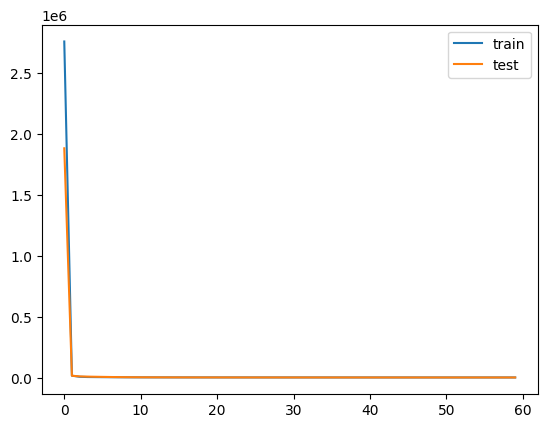

In [37]:
plt.plot(losses, label='train')
plt.plot(losses_test, label='test')
plt.legend()
plt.show()